####  Applying Synthetic Minority Oversampling Technique (SMOTE)

In [1]:
# ! pip install gensim

In [40]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import numpy as np
from pprint import pprint as pp
import csv
from pathlib import Path
import seaborn as sns
from itertools import product
import string

from xgboost import XGBClassifier

from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import BorderlineSMOTE
from imblearn.pipeline import Pipeline 

from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import r2_score, classification_report, confusion_matrix, accuracy_score, roc_auc_score, roc_curve, precision_recall_curve, average_precision_score
from sklearn.metrics import homogeneity_score, silhouette_score
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import MiniBatchKMeans, DBSCAN
from sklearn.preprocessing import LabelEncoder

from sklearn.utils import resample

import lightgbm as lgb
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix



In [4]:
df_train = pd.read_csv("InsNova_data_2023_train.csv", index_col='id')

In [5]:
def prep_data(df: pd.DataFrame) -> (np.ndarray, np.ndarray):
    """
    Convert the DataFrame into two variable
    X: data columns (V1 - V28)
    y: lable column
    """
    X = df.iloc[:,1:19].values
    y = df.clm.values
    return X, y

In [6]:
X, y = prep_data(df_train)

In [7]:
def plot_data(X: np.ndarray, y: np.ndarray):
    plt.scatter(X[y == 0, 0], X[y == 0, 15], label="Class #0", alpha=0.5, linewidth=0.15)
    plt.scatter(X[y == 1, 0], X[y == 1, 15], label="Class #1", alpha=0.5, linewidth=0.15, c='r')
    plt.legend()
    return plt.show()

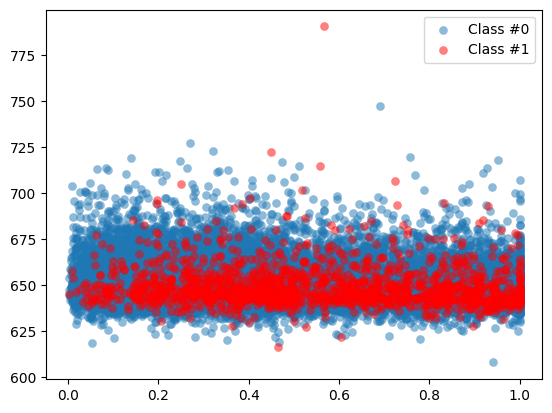

In [8]:
plot_data(X, y)

In [9]:
# X.shape

In [10]:
# from collections import Counter
# from sklearn.datasets import make_classification
# from imblearn.over_sampling import RandomOverSampler
# from imblearn.under_sampling import RandomUnderSampler

In [11]:
# method = RandomOverSampler(sampling_strategy=0.1)


In [12]:
# X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=42)

In [13]:
# X, y = method.fit_resample(X_train, y_train)

In [14]:
# X.shape, X_train.shape

In [15]:
def addlogs(res, cols):
    """ Log transform feature list"""
    m = res.shape[1]
    for c in cols:
        res = res.assign(newcol=pd.Series(np.log(1.01+res[c])).values)   
        res.columns.values[m] = c + '_log'
        m += 1
    return res

Some basic calculated cols

Add Log transform columns for simple integer features.

In [16]:
loglist = ['max_power', 'driving_history_score']

df_train = addlogs(df_train, loglist)
df_train = df_train.drop(loglist, axis=1)

In [17]:
df_train.sample(3)

,veh_value,exposure,veh_body,veh_age,gender,area,agecat,engine_type,veh_color,marital_status,...,time_of_week_driven,time_driven,trm_len,credit_score,high_education_ind,clm,numclaims,claimcst0,max_power_log,driving_history_score_log
id,,,,,,,,,,,,,,,,,,,,,
3004,1.04,0.270030,SEDAN,4,F,A,3,petrol,white,M,...,weekend,12am - 6 am,6,663.982269,0.0,0,0,0.0,4.969883,4.477450
11089,1.78,0.343811,SEDAN,2,F,B,4,petrol,black,M,...,weekend,12pm - 6pm,12,646.951714,0.0,0,0,0.0,4.700571,4.605270
18562,6.43,0.241898,STNWG,1,M,A,3,dissel,green,S,...,weekday,12pm - 6pm,12,651.511518,0.0,0,0,0.0,5.181840,4.174541


In [18]:
df_train = df_train.drop(['claimcst0', 'numclaims'], axis=1)

In [19]:
df_train["high_education_ind"] = (df_train["high_education_ind"]).astype(int)

In [20]:
def transform_to_object(lis):
    for i in lis:
        df_train[lis] = df_train[lis].astype(str)

In [21]:
transform_to_object(['veh_age', 'agecat', 'e_bill', 'trm_len', 'high_education_ind'])

In [22]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 22619 entries, 1 to 22619
Data columns (total 19 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   veh_value                  22619 non-null  float64
 1   exposure                   22619 non-null  float64
 2   veh_body                   22619 non-null  object 
 3   veh_age                    22619 non-null  object 
 4   gender                     22619 non-null  object 
 5   area                       22619 non-null  object 
 6   agecat                     22619 non-null  object 
 7   engine_type                22619 non-null  object 
 8   veh_color                  22619 non-null  object 
 9   marital_status             22619 non-null  object 
 10  e_bill                     22619 non-null  object 
 11  time_of_week_driven        22619 non-null  object 
 12  time_driven                22619 non-null  object 
 13  trm_len                    22619 non-null  obj

## Handle categoricals
First some util functions to dummy encode the categoricals. LightGBM can handle these natively but for now we do it manually as this could then easily be applied a pre process step for other algorithms.

In [23]:
y = df_train["clm"]
y.sample(3)

id
15537    0
14271    0
4560     0
Name: clm, dtype: int64

In [24]:
df_train = df_train.drop('clm', axis=1)

In [25]:
df_train.head(3)

,veh_value,exposure,veh_body,veh_age,gender,area,agecat,engine_type,veh_color,marital_status,e_bill,time_of_week_driven,time_driven,trm_len,credit_score,high_education_ind,max_power_log,driving_history_score_log
id,,,,,,,,,,,,,,,,,,
1,0.77,0.444504,SEDAN,4,M,D,3,petrol,black,S,1,weekday,6pm - 12am,6,640.448137,1,4.997280,4.219655
2,4.45,0.562183,STNWG,1,M,A,3,petrol,white,S,1,weekday,6am - 12pm,12,683.749691,0,5.068967,4.343935
3,4.90,0.465244,STNWG,1,F,A,3,petrol,black,M,1,weekday,6pm - 12am,6,653.656117,1,5.075236,4.077707


In [26]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 22619 entries, 1 to 22619
Data columns (total 18 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   veh_value                  22619 non-null  float64
 1   exposure                   22619 non-null  float64
 2   veh_body                   22619 non-null  object 
 3   veh_age                    22619 non-null  object 
 4   gender                     22619 non-null  object 
 5   area                       22619 non-null  object 
 6   agecat                     22619 non-null  object 
 7   engine_type                22619 non-null  object 
 8   veh_color                  22619 non-null  object 
 9   marital_status             22619 non-null  object 
 10  e_bill                     22619 non-null  object 
 11  time_of_week_driven        22619 non-null  object 
 12  time_driven                22619 non-null  object 
 13  trm_len                    22619 non-null  obj

In [27]:
# categorical_columns = ['veh_body', 'veh_age', 'gender', 'area',
#        'agecat', 'engine_type', 'veh_color', 'marital_status', 'e_bill',
#        'time_of_week_driven', 'time_driven', 'trm_len',
#        'high_education_ind']
def encoder():
    label_encoder = LabelEncoder()
    for column in df_train.columns:
        if df_train[column].dtype == 'object':
            df_train[column] = label_encoder.fit_transform(df_train[column])

In [28]:
encoder()

In [29]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 22619 entries, 1 to 22619
Data columns (total 18 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   veh_value                  22619 non-null  float64
 1   exposure                   22619 non-null  float64
 2   veh_body                   22619 non-null  int64  
 3   veh_age                    22619 non-null  int64  
 4   gender                     22619 non-null  int64  
 5   area                       22619 non-null  int64  
 6   agecat                     22619 non-null  int64  
 7   engine_type                22619 non-null  int64  
 8   veh_color                  22619 non-null  int64  
 9   marital_status             22619 non-null  int64  
 10  e_bill                     22619 non-null  int64  
 11  time_of_week_driven        22619 non-null  int64  
 12  time_driven                22619 non-null  int64  
 13  trm_len                    22619 non-null  int

In [30]:
X_train, X_test, y_train, y_test = train_test_split(df_train, y, test_size=0.25, random_state=42)

In [31]:
# smote = SMOTE(random_state=42)

In [32]:
# X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

In [34]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((16964, 18), (16964,), (5655, 18), (5655,))

In [36]:
df_train = pd.concat([X_train, y_train], axis=1)


In [37]:
majority_class = df_train[df_train['clm'] == 0]
minority_class = df_train[df_train['clm'] == 1]

In [38]:
majority_class.shape, minority_class.shape

((15819, 19), (1145, 19))

In [41]:

minority_class_oversampled = resample(minority_class, replace=True, n_samples=len(majority_class), random_state=42)

In [42]:
minority_class_oversampled.shape

(15819, 19)

In [43]:
undersampled_df = pd.concat([minority_class_oversampled, majority_class])

In [44]:
undersampled_df.columns

Index(['veh_value', 'exposure', 'veh_body', 'veh_age', 'gender', 'area',
       'agecat', 'engine_type', 'veh_color', 'marital_status', 'e_bill',
       'time_of_week_driven', 'time_driven', 'trm_len', 'credit_score',
       'high_education_ind', 'max_power_log', 'driving_history_score_log',
       'clm'],
      dtype='object')

In [45]:
Y_train = undersampled_df["clm"]

In [47]:
undersampled_df.drop(["clm"], axis=1, inplace=True)
# The fix missing cols above will have added the target column to the test data frame, so this is a workaround to remove it
# df_test.drop(["claimcst0"], axis=1, inplace=True) 

In [51]:
print("Shape train: %s, test: %s" % (undersampled_df.shape))

Shape train: 31638, test: 18


In [55]:
X_train_oversample = undersampled_df

In [56]:
X_train_oversample.shape

(31638, 18)

In [57]:
# X_train_resampled.shape

In [79]:
hyper_params = {
    'task': 'train',
    'boosting_type': 'gbdt',
    'objective': 'binary',
    'metric': 'binary_logloss',
    'learning_rate': 0.01,
    'feature_fraction': 0.9,
    'bagging_fraction': 0.7,
    'bagging_freq': 20,
    'verbose': -1,
    "max_depth": 10,
    "num_leaves": 100,  
    "max_bin": 512,
    'early_stopping_round': 100
}

In [80]:
lgb_train = lgb.Dataset(X_train_oversample, Y_train)
lgb_eval = lgb.Dataset(X_test, y_test, reference=lgb_train)

In [81]:
model = lgb.train(hyper_params,
                 train_set=lgb_train,
                 valid_sets=lgb_eval,
                 num_boost_round=1000)

In [82]:
model.best_iteration

1000

In [83]:
Y_pred_lgb = model.predict(X_test, num_iteration=model.best_iteration)

In [84]:
y_pred_binary_lgb = np.round(Y_pred_lgb)

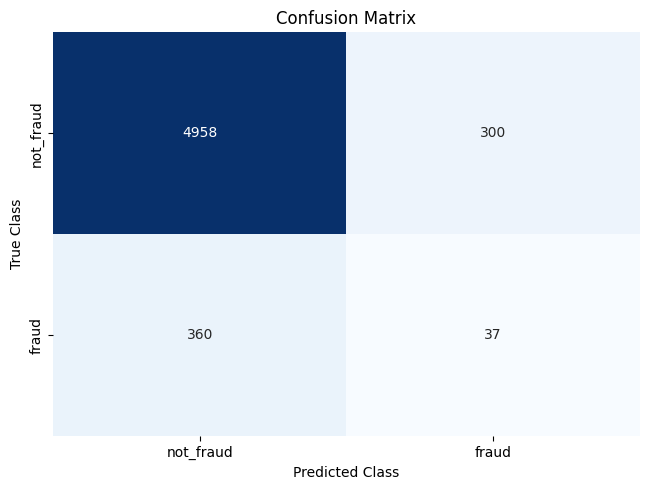

In [85]:
class_names = ['not_fraud', 'fraud']
matrix = confusion_matrix(y_test, y_pred_binary_lgb)
# Create pandas dataframe
dataframe = pd.DataFrame(matrix, index=class_names, columns=class_names)
# Create heatmap
sns.heatmap(dataframe, annot=True, cbar=None, cmap="Blues", fmt = 'g')
plt.title("Confusion Matrix"), plt.tight_layout()
plt.ylabel("True Class"), plt.xlabel("Predicted Class")
plt.show()

In [142]:
print(classification_report(y_test, y_pred_binary_lgb))

              precision    recall  f1-score   support

           0       0.93      0.97      0.95      5258
           1       0.07      0.03      0.04       397

    accuracy                           0.91      5655
   macro avg       0.50      0.50      0.49      5655
weighted avg       0.87      0.91      0.89      5655



In [143]:

accuracy = accuracy_score(y_test, y_pred_binary_lgb)
precision = precision_score(y_test, y_pred_binary_lgb)
recall = recall_score(y_test, y_pred_binary_lgb)
f1 = f1_score(y_test, y_pred_binary_lgb)
conf_matrix = confusion_matrix(y_test, y_pred_binary_lgb)
auc = roc_auc_score(y_test, y_pred_binary_lgb)




In [144]:
accuracy, precision, recall, f1, auc

(0.9050397877984084,
 0.06790123456790123,
 0.027707808564231738,
 0.03935599284436494,
 0.4994948323916632)

In [87]:
Y_train.value_counts()
ratio = float(Y_train.value_counts()[0]) / Y_train.value_counts()[1]

In [149]:
params = { 'boosting_type': 'gbdt',
    'objective': 'binary:logistic',
    'metric': 'binary_logloss',
    'learning_rate': 0.05,
    'feature_fraction': 0.8,
    'bagging_fraction': 0.8,
    'bagging_freq': 10,
    'verbose': -1,
    'max_depth': 8,
    'max_leaves': 200,  
    'max_bin': 200,
    'early_stopping_round': 100
}

In [150]:
import xgboost as xgb

# Set class weights
# class_weights = {0: 1, 1: 10}  # Class 0: 1, Class 1: 10

# Train XGBoost model
model = xgb.XGBClassifier(**params)
model.fit(X_train_oversample, Y_train)

/home/ftahmed/.local/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [01:17:10] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "bagging_fraction", "bagging_freq", "boosting_type", "early_stopping_round", "feature_fraction", "metric", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


XGBClassifier(bagging_fraction=0.8, bagging_freq=10, base_score=None,
              booster=None, boosting_type='gbdt', callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_round=100,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_fraction=0.8, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.05, max_bin=200,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=8, max_leaves=200,
              metric='binary_logloss', min_child_weight=None, missing=nan, ...)

In [151]:
pred_xgb = model.predict(X_test)

In [152]:
y_pred_binary_xgb = np.round(pred_xgb)

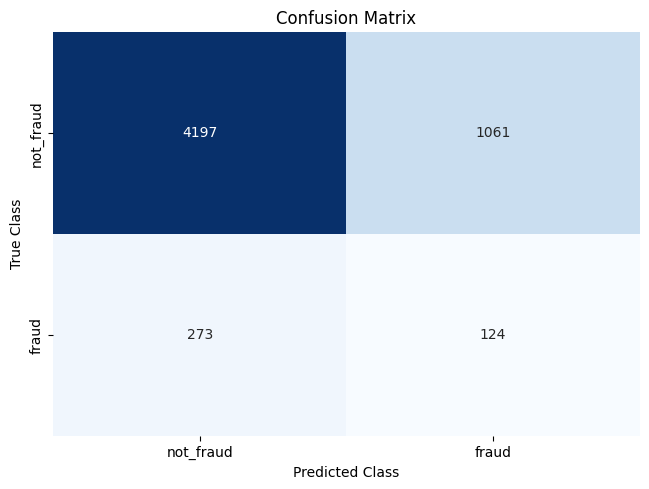

In [153]:
class_names = ['not_fraud', 'fraud']
matrix = confusion_matrix(y_test, y_pred_binary_xgb)
# Create pandas dataframe
dataframe = pd.DataFrame(matrix, index=class_names, columns=class_names)
# Create heatmap
sns.heatmap(dataframe, annot=True, cbar=None, cmap="Blues", fmt = 'g')
plt.title("Confusion Matrix"), plt.tight_layout()
plt.ylabel("True Class"), plt.xlabel("Predicted Class")
plt.show()

In [55]:
print(classification_report(y_test, y_pred_binary_xgb))

              precision    recall  f1-score   support

           0       0.93      0.72      0.81      5258
           1       0.08      0.34      0.13       397

    accuracy                           0.69      5655
   macro avg       0.51      0.53      0.47      5655
weighted avg       0.88      0.69      0.76      5655



In [156]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

accuracy = accuracy_score(y_test, y_pred_binary_xgb)
precision = precision_score(y_test, y_pred_binary_xgb)
recall = recall_score(y_test, y_pred_binary_xgb)
f1 = f1_score(y_test, y_pred_binary_xgb)
conf_matrix = confusion_matrix(y_test, y_pred_binary_xgb)
auc = roc_auc_score(y_test, y_pred_binary_xgb)


In [64]:
accuracy, precision, recall, f1, auc

(0.6919540229885057,
 0.08307501549907005,
 0.33753148614609574,
 0.13333333333333333,
 0.528122913099674)

In [65]:
from sklearn.metrics import roc_auc_score, f1_score


In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

In [ ]:
for th in range(1,11,1):
    th = th / 10
    y_pred = (y_pred_proba > th).astype(int)
    f1 = f1_score(y_test, y_pred)
    print(f"Threshold: {th} - F1: {f1}")

In [154]:
model_lR = LogisticRegression(penalty='l2', C=1.0, max_iter=1000)
model_lR.fit(X_train_resampled, y_train_resampled.values.ravel())

LogisticRegression(max_iter=1000)

In [155]:
pred_lR = model_lR.predict(X_test)

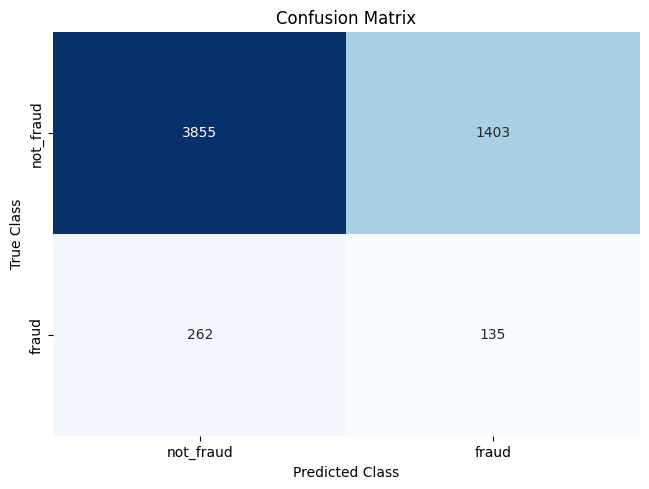

In [156]:
class_names = ['not_fraud', 'fraud']
matrix = confusion_matrix(y_test, pred_lR)
# Create pandas dataframe
dataframe = pd.DataFrame(matrix, index=class_names, columns=class_names)
# Create heatmap
sns.heatmap(dataframe, annot=True, cbar=None, cmap="Blues", fmt = 'g')
plt.title("Confusion Matrix"), plt.tight_layout()
plt.ylabel("True Class"), plt.xlabel("Predicted Class")
plt.show()

In [157]:
print(classification_report(y_test, pred_lR))

              precision    recall  f1-score   support

           0       0.94      0.73      0.82      5258
           1       0.09      0.34      0.14       397

    accuracy                           0.71      5655
   macro avg       0.51      0.54      0.48      5655
weighted avg       0.88      0.71      0.77      5655



In [160]:
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score
# svm_classifier = SVC(kernel='poly', degree=2)  # Example with a linear kernel
# svm_classifier.fit(X_train_resampled, y_train_resampled)

clf = SVC(kernel='rbf', C=1)
scores = cross_val_score(clf, X_train_oversample, Y_train, cv=2)
print(scores)


[0.50597383 0.49845123]


In [161]:
clf.fit(X_train_oversample, Y_train)
y_pred_svm = clf.predict(X_test)


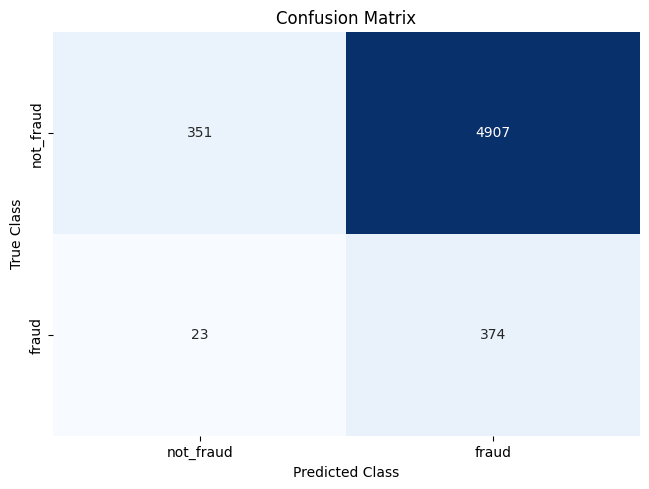

In [162]:
class_names = ['not_fraud', 'fraud']
matrix = confusion_matrix(y_test, y_pred_svm)
# Create pandas dataframe
dataframe = pd.DataFrame(matrix, index=class_names, columns=class_names)
# Create heatmap
sns.heatmap(dataframe, annot=True, cbar=None, cmap="Blues", fmt = 'g')
plt.title("Confusion Matrix"), plt.tight_layout()
plt.ylabel("True Class"), plt.xlabel("Predicted Class")
plt.show()

In [ ]:
print(classification_report(y_test, y_pred_svm))

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)


In [170]:
data_dmatrix = xgb.DMatrix(data=X_train_resampled,label=y_train_resampled)

In [171]:
from xgboost import cv

params = {"objective":"binary:logistic",'colsample_bytree': 0.3,'learning_rate': 0.1,
                'max_depth': 5, 'alpha': 10}

xgb_cv = xgb.cv(dtrain=data_dmatrix, params=params, nfold=5,
                    num_boost_round=10000, early_stopping_rounds=100, metrics="auc", as_pandas=True, seed=123)

In [172]:
xgb_cv.head()

,train-auc-mean,train-auc-std,test-auc-mean,test-auc-std
0,0.743147,0.002198,0.741308,0.008599
1,0.787702,0.001332,0.785225,0.007300
2,0.791652,0.001437,0.788245,0.006945
3,0.797061,0.001470,0.792945,0.005918
4,0.814030,0.000869,0.809521,0.005289


In [173]:
len(xgb_cv)

1042

In [174]:
best_clf = xgb.train(params, data_dmatrix, num_boost_round=10000)

In [175]:
new_data_dmatrix = xgb.DMatrix(X_test)
new_predictions = best_clf.predict(new_data_dmatrix)

In [176]:
new_binary_predictions = np.round(new_predictions)


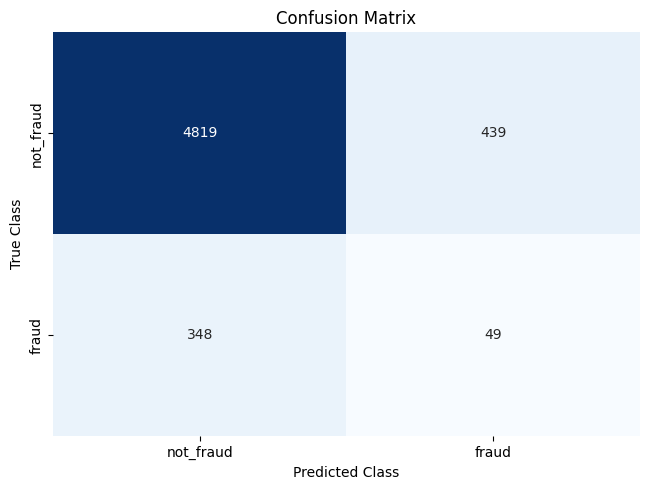

In [177]:
class_names = ['not_fraud', 'fraud']
matrix = confusion_matrix(y_test, new_binary_predictions)
# Create pandas dataframe
dataframe = pd.DataFrame(matrix, index=class_names, columns=class_names)
# Create heatmap
sns.heatmap(dataframe, annot=True, cbar=None, cmap="Blues", fmt = 'g')
plt.title("Confusion Matrix"), plt.tight_layout()
plt.ylabel("True Class"), plt.xlabel("Predicted Class")
plt.show()

In [179]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVR
from xgboost import XGBRegressor
from lightgbm import LGBMClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.pipeline import make_pipeline
from sklearn.metrics import mean_squared_error

# # Load the CSV dataset
# data = pd.read_csv('your_dataset.csv')

# # Split the dataset into features and target variable
# X = data.drop('target_variable', axis=1)
# y = data['target_variable']

# Split the data into training and testing sets
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define the pipeline
pipeline = make_pipeline(
    StandardScaler(),
    VotingClassifier([
        # ('svmRbf', SVC(kernel='rbf', C=1)),
        ('lgb', LGBMClassifier(boosting_type = 'gbdt',
                               num_leaves = 100,
                               max_depth = 10,
                               learning_rate = 0.01,
                               feature_fraction = 0.9,
                               bagging_fraction = 0.7,
                               bagging_freq = 10,
                               n_estimators = 1000,
                               # subsample_for_bin = 20000,
                               max_leaves = 100,
                               max_bin = 200)),
        ('svmPoly', SVC(kernel='poly', degree=3)),
        ('xgb', XGBClassifier( boosting_type = 'gbdt',
                              learning_rate = 0.01,
                              feature_fraction = 0.9,
                              bagging_fraction = 0.7,
                              bagging_freq = 10,
                              verbose = -1,
                              max_depth = 10,
                              max_leaves = 100,
                              max_bin = 200,
                              early_stopping_round = 100))
    ])
)

# Fit the pipeline on the training data
pipeline.fit(X_train_oversample, Y_train)

# Predict on the test data
y_pred = pipeline.predict(X_test)

# Evaluate the model using mean squared error
# mse = mean_squared_error(y_test, y_pred)
# print("Mean Squared Error:", mse)
matrix = confusion_matrix(y_test, y_pred)
print(matrix)

[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] num_leaves is set=100, max_leaves=100 will be ignored. Current value: num_leaves=100
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] num_leaves is set=100, max_leaves=100 will be ignored. Current value: num_leaves=100
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10
[LightGBM] [Info] Number of positive: 15819, number of negative: 15819
[LightGBM] [Inf

/home/ftahmed/.local/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [12:21:02] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "bagging_fraction", "bagging_freq", "boosting_type", "early_stopping_round", "feature_fraction", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] num_leaves is set=100, max_leaves=100 will be ignored. Current value: num_leaves=100
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10
[[4086 1172]
 [ 254  143]]


In [180]:
matrix = confusion_matrix(y_test, y_pred)
print(matrix)

[[4086 1172]
 [ 254  143]]


In [ ]:
LGBMClassifier

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier



clf = GradientBoostingClassifier(n_estimators=100, learning_rate=1.0, 
                                 max_depth=1, random_state=0).fit(X_train, y_train)
clf.score(X_test, y_test)